# ARIMA

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

### Загружаем данные

In [4]:
df = pd.read_csv('Processed_NYSE.csv')

In [5]:
df.head()

,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,7184.959961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,7326.740234,0.921723,0.019733,NaN,NaN,NaN,NaN,NaN,NaN,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,7354.870117,-0.375903,0.003839,0.019733,NaN,NaN,NaN,NaN,NaN,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,7377.700195,0.996234,0.003104,0.003839,0.019733,NaN,NaN,NaN,NaN,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,7393.930176,0.059932,0.002200,0.003104,0.003839,0.019733,NaN,NaN,NaN,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58


In [6]:
df = df.fillna(df.mean())

In [7]:
df.Date = pd.DatetimeIndex(df.Date)
df = df.sort_values(by='Date')
df.index = pd.DatetimeIndex(df.Date)

In [8]:
idx = pd.date_range(df.Date.min(), df.Date.max())
df = df.reindex(idx, method='nearest')

In [9]:
exog = df.drop(['Close', 'Name'], axis=1)

In [10]:
df = df[['Close', 'Date']]

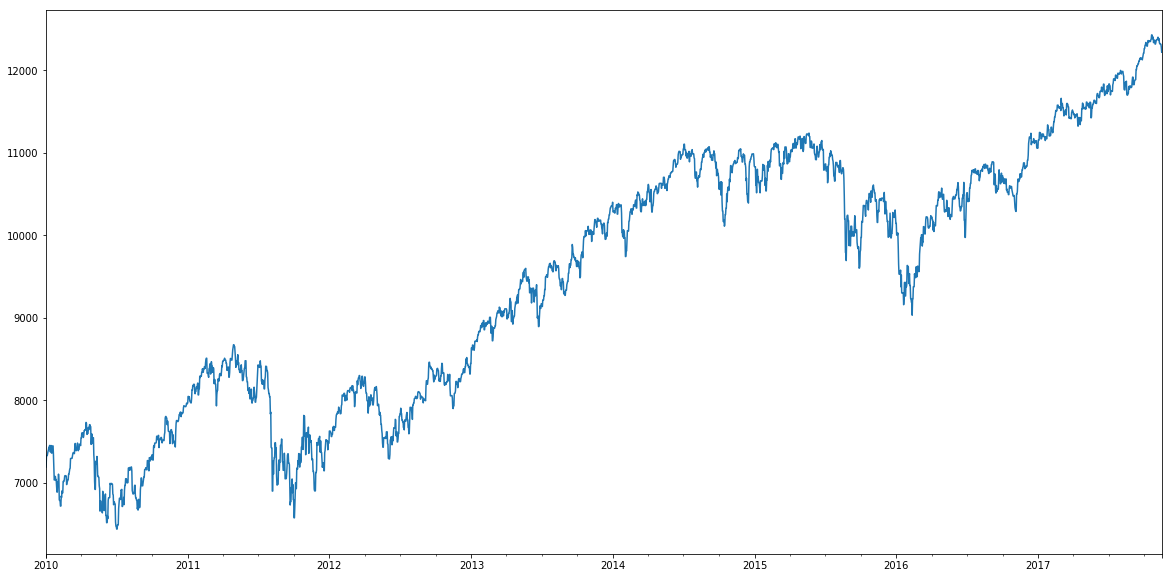

In [11]:
figsize(20, 10)
df.Close.plot()

Берём, начиная с 2016 года

In [12]:
df = df.loc['2016-01-01':]
exog = exog.loc['2016-01-01':]

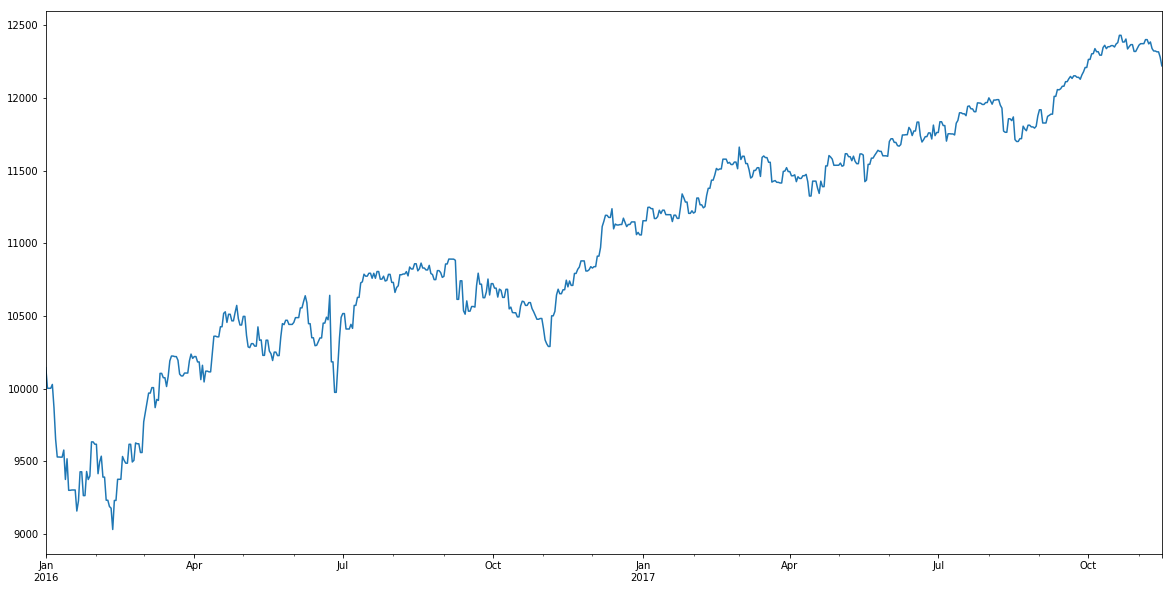

In [13]:
df.Close.plot()

In [17]:
df['CloseLog'] = np.log(df.Close)
df['CloseLogShift1'] = df.CloseLog.shift()

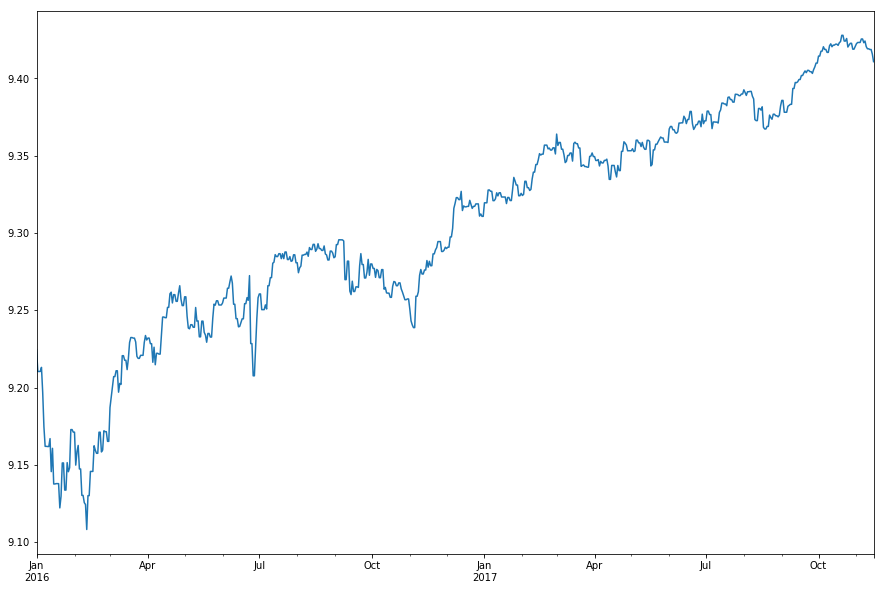

In [32]:
df.CloseLog.plot()

### Разложение

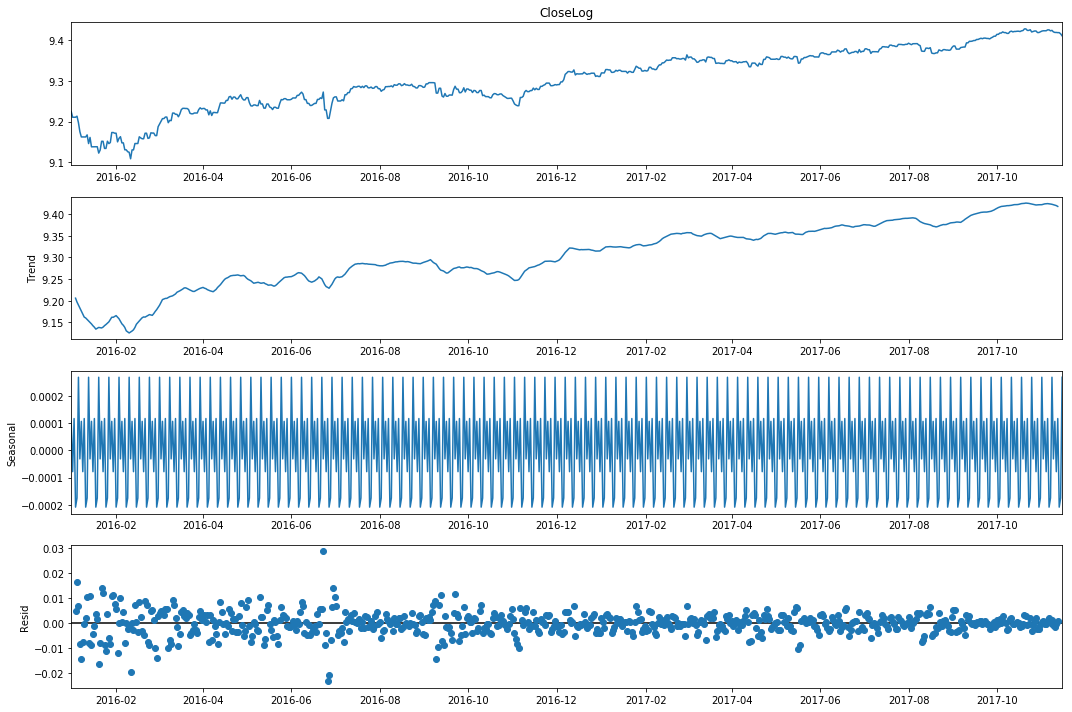

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df.CloseLog).plot()
plt.show()

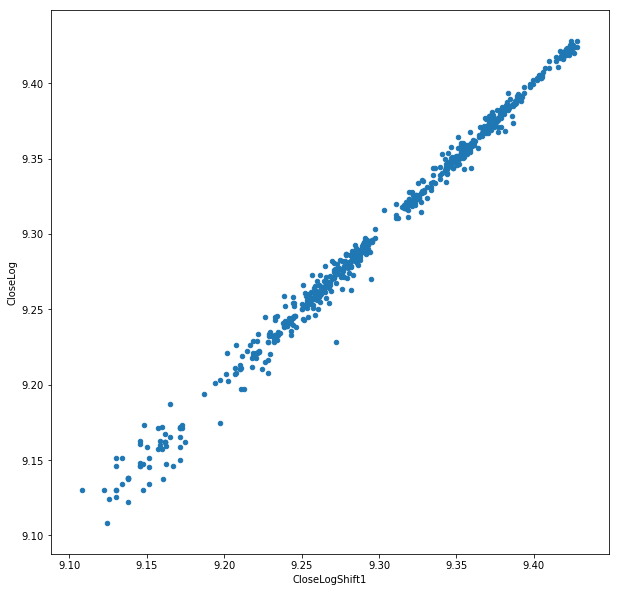

In [18]:
figsize(10, 10)
df.plot(kind='scatter', y='CloseLog', x='CloseLogShift1')

### Автокорреляции

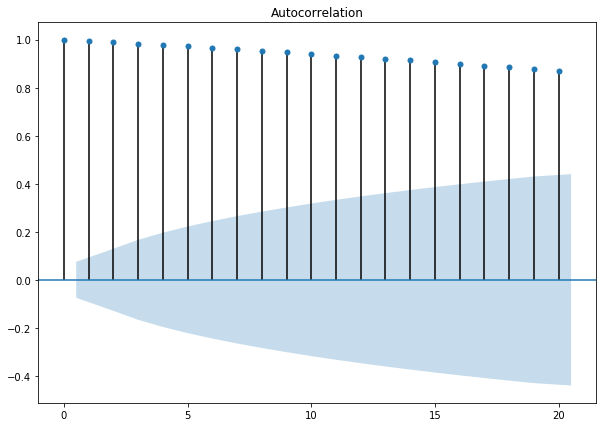

In [139]:
sm.graphics.tsa.plot_acf(df['CloseLog'].values.squeeze(), lags=20)
plt.show()

In [20]:
df['CloseLogDiff'] = df.CloseLog - df.CloseLogShift1

### Разности первого порядка

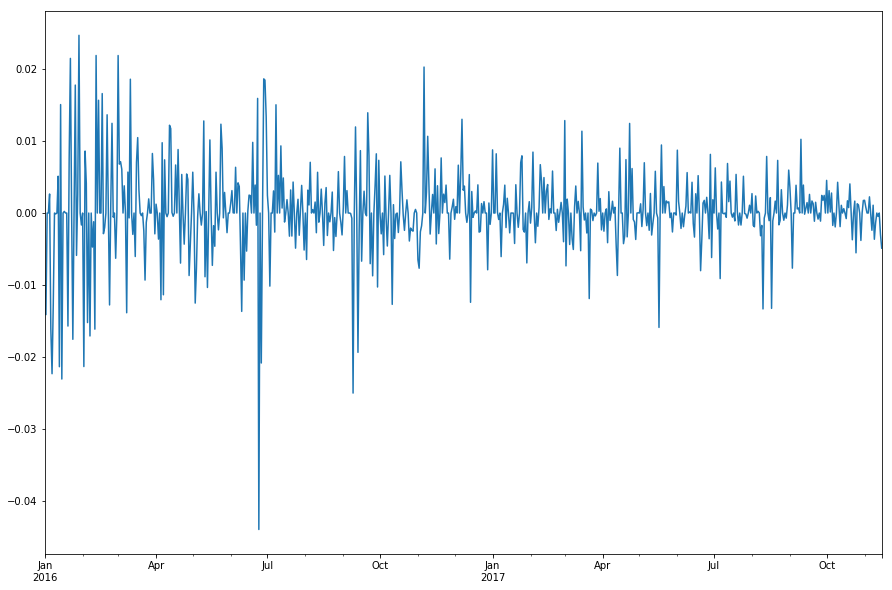

In [21]:
figsize(15, 10)
df.CloseLogDiff.plot()

### Разности второго порядка

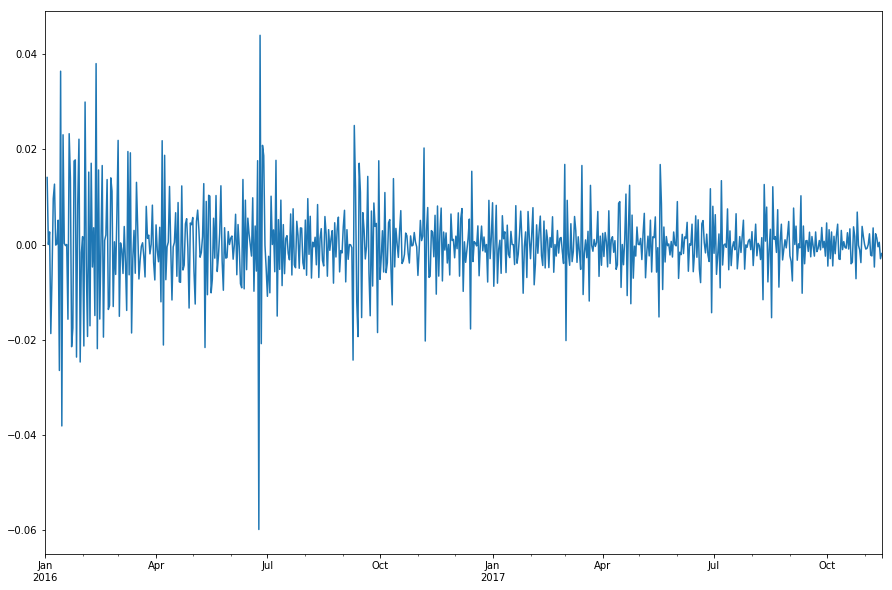

In [22]:
(df.CloseLog.diff()).diff().plot()

ACF и PACF для разностей первого порядка

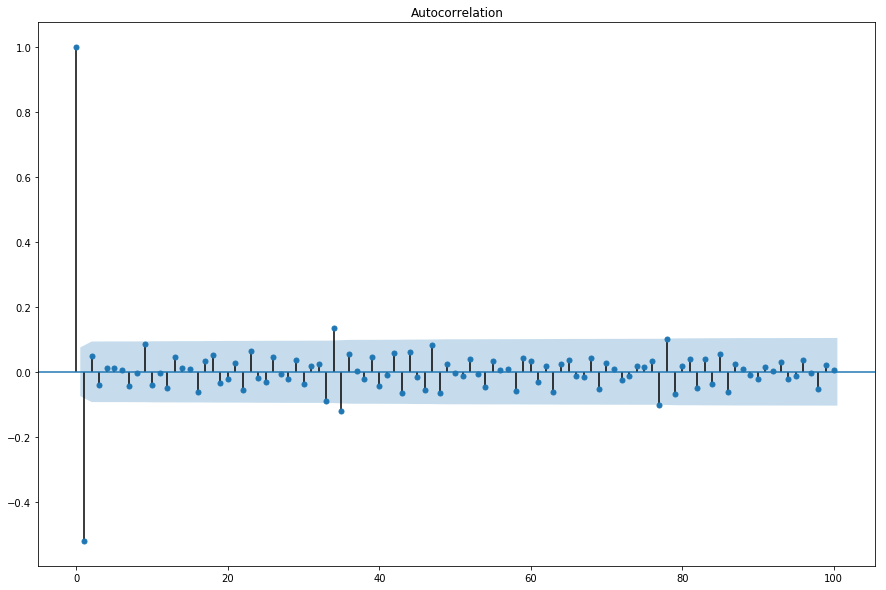

In [40]:
sm.graphics.tsa.plot_acf(df['CloseLogDiff'].diff().dropna().values.squeeze(), lags=100)
plt.show()

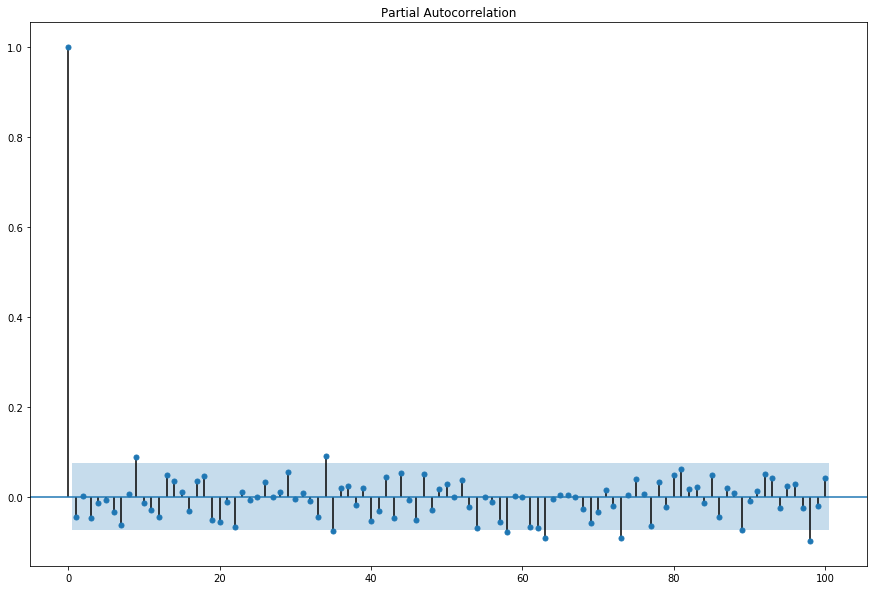

In [41]:
sm.graphics.tsa.plot_pacf(df['CloseLogDiff'].dropna().values.squeeze(), lags=100)
plt.show()

### Стационарность

Стационарность исходного ряда

In [23]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.CloseLog)[1])

Критерий Дики-Фуллера: p=0.700444


Стационарность ряда разностей

In [36]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.CloseLog[1:])[1])

Критерий Дики-Фуллера: p=0.000000


## Построение модели ARIMA

In [44]:
df_train = df.loc[:'2017-05-01']
df_test = df.loc['2017-05-01':]

In [46]:
ts_train = df_train.CloseLog
ts_test = df_test.CloseLog

In [114]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(ts_train, order=(50, 2, 30))
arima_res = arima_model.fit()

/home/dasha/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [120]:
import datetime

start_index = '2017-04-01'
end_index = '2017-11-15'
forecast = arima_res.predict(start=pd.to_datetime(start_index),
                             end=pd.to_datetime(end_index))

In [143]:
forecast_exp = np.exp(forecast)

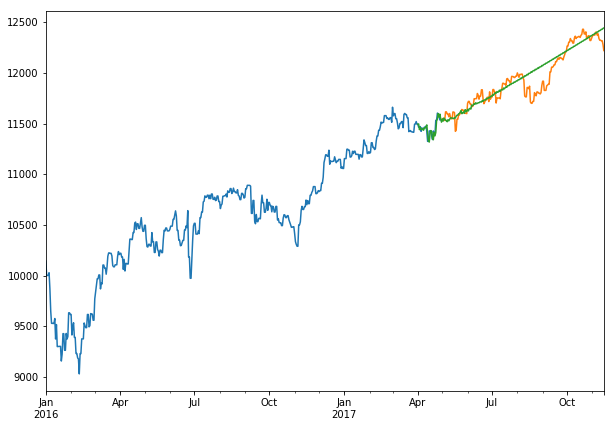

In [142]:
df_train.Close.plot()
df_test.Close.plot()
forecast_exp.plot()

In [144]:
from sklearn.metrics import mean_squared_error

print('MSE', mean_squared_error(df_test.Close, forecast_exp['2017-05-01':]))
print('RMSE', np.sqrt(mean_squared_error(df_test.Close, forecast_exp['2017-05-01':])))

MSE 11560.785770455597
RMSE 107.52109453709815
